In [488]:
import pathlib
import random
import pandas as pd
import numpy as np
import sys
import nltk

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

sns.set(style='darkgrid')

from sklearn.metrics import (
    f1_score, 
    accuracy_score,
    classification_report, 
)

ROOT_DIR = pathlib.Path().absolute()
DATA_DIR = ROOT_DIR / "data"
RANDOM_SEED = 42

## Загрузка и обзор данных

In [489]:
df_trends = pd.read_csv(DATA_DIR / "trends_description.csv")
df = pd.read_csv(DATA_DIR / "train.csv")
df_test = pd.read_csv(DATA_DIR / "test.csv")
df_test_copy=df_test.copy()



In [490]:
for i in range(50):
    df.rename(columns={f"trend_id_res{i}": i}, inplace=True)
#df["labels"] = df.drop('index',axis=1).drop('assessment',axis=1).drop('tags',axis=1).drop('text',axis=1).drop('Unnamed: 0',axis=1).apply(lambda r: r.index[r.ne(0)].to_list(), axis=1)
df.head()

,Unnamed: 0,index,assessment,tags,text,0,1,2,3,4,...,40,41,42,43,44,45,46,47,48,49
0,0,5652,6.0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортимент больше, а так вроде бы все хорошо",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,18092,4.0,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,13845,6.0,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}",Доставка постоянно задерживается,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3,25060,6.0,"{PRICE,PROMOTIONS,ASSORTMENT}",Наценка и ассортимент расстраивают,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1428,6.0,"{PRICE,PROMOTIONS}","Можно немного скинуть минимальную сумму заказа или оплачивать доставку ,если сумма меньше,как в Яндекс маркете",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Обучение моделей

### Предобработка данных

In [491]:
df.head()

,Unnamed: 0,index,assessment,tags,text,0,1,2,3,4,...,40,41,42,43,44,45,46,47,48,49
0,0,5652,6.0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортимент больше, а так вроде бы все хорошо",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,18092,4.0,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,13845,6.0,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}",Доставка постоянно задерживается,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3,25060,6.0,"{PRICE,PROMOTIONS,ASSORTMENT}",Наценка и ассортимент расстраивают,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1428,6.0,"{PRICE,PROMOTIONS}","Можно немного скинуть минимальную сумму заказа или оплачивать доставку ,если сумма меньше,как в Яндекс маркете",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


C:\Users\Katie\AppData\Local\Temp\ipykernel_21676\47135135.py:2: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


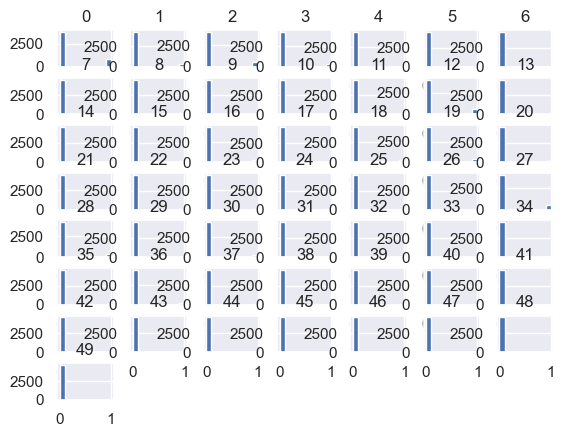

In [492]:
df.drop(columns=['index','Unnamed: 0', 'assessment']).hist()
plt.tight_layout()
plt.show()

In [493]:
df.drop(columns=['index','Unnamed: 0', 'assessment'],axis=1, inplace=True)
df.head()

,tags,text,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортимент больше, а так вроде бы все хорошо",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}",Доставка постоянно задерживается,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"{PRICE,PROMOTIONS,ASSORTMENT}",Наценка и ассортимент расстраивают,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"{PRICE,PROMOTIONS}","Можно немного скинуть минимальную сумму заказа или оплачивать доставку ,если сумма меньше,как в Яндекс маркете",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [494]:


X_train, X_val, y_train, y_val = train_test_split(df.iloc[:, :2], df.iloc[:, 2:], test_size=0.05, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)



(4391, 2) (232, 2) (4391, 50) (232, 50)


In [495]:
X_train.head()

,tags,text
2897,"{DELIVERY,ASSORTMENT}","К сожалению, сумма минимального заказа сильно выросла за последние [NUM]-[NUM] месяцев. Из-за этого, когда нужно купить [NUM]-[NUM] позиции, выбираю другую службу доставки."
3638,"{PRODUCTS_QUALITY,DELIVERY}",У половины курьеров нет документов
811,"{ASSORTMENT,PRICE,PROMOTIONS,PAYMENT}",Жаль нет оплаты за наличный расчет
3404,"{PRODUCTS_QUALITY,DELIVERY}",Овощи практически всегда не свежие и доставка [NUM]-[NUM] мину
2222,"{DELIVERY,SUPPORT}","Не берут трубку и сбрасывают, курьер не приезжает в назначенное воемя"


<Axes: >

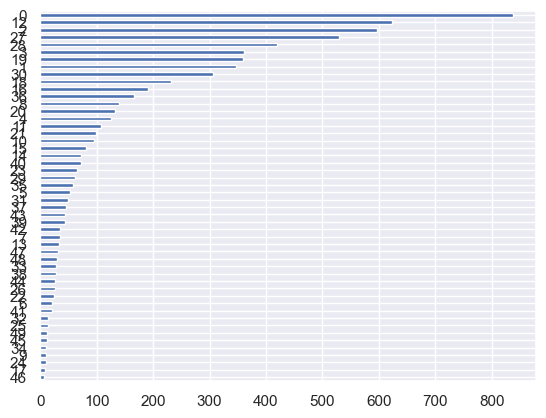

In [544]:
LABEL_COLUMNS = df.columns.tolist()[2:]

df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh")

In [497]:
def preprocess_text(data):
  data = data['text'] 

  tfidf_vectorizer = TfidfVectorizer(max_features=3)
  data_vectorized = tfidf_vectorizer.fit_transform(data)
  return data_vectorized


In [498]:


X_train = preprocess_text(X_train)
X_val = preprocess_text(X_val)
print(X_train.shape, X_val.shape)
df_test.head()



(4391, 3) (232, 3)


,Unnamed: 0,index,assessment,tags,text
0,1,3135,3.0,{DELIVERY},"Последнее время думаю плохо, сроки доставки давно не [NUM] мин, а цена услуг при этом выше аналогов"
1,3,4655,2.0,"{PRICE,DELIVERY,ASSORTMENT}",Цены намного выше магазинных но радуют акции
2,5,22118,2.0,"{CATALOG_NAVIGATION,ASSORTMENT,DELIVERY}","Доставка за [NUM] минут, заказ даже не начали собирать спустя [NUM] минут"
3,7,23511,0.0,{DELIVERY},Ужасно долгая доставка
4,8,45,6.0,"{ASSORTMENT,PROMOTIONS}",Добрый вечер! Вы большие молодцы. Меня всё устраивает. За исключением некоторых ребят на доставке.


In [499]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

input_shape = X_train.shape[1]
num_labels = y_train.shape[1]

# model architecture
model = Sequential([
    Dense(512, input_shape=(input_shape,), activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_labels, activation='sigmoid')
])

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# model summary
model.summary() 

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 512)               2048      
                                                                 
 dropout_30 (Dropout)        (None, 512)               0         
                                                                 
 dense_46 (Dense)            (None, 128)               65664     
                                                                 
 dropout_31 (Dropout)        (None, 128)               0         
                                                                 
 dense_47 (Dense)            (None, 50)                6450      
                                                                 
Total params: 74,162
Trainable params: 74,162
Non-trainable params: 0
_________________________________________________________________


In [500]:
history = model.fit(X_train.toarray(), y_train.values, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
110/110 [==============================] - 2s 7ms/step - loss: 0.6570 - accuracy: 0.0157 - val_loss: 0.5807 - val_accuracy: 0.0068
Epoch 2/100
110/110 [==============================] - 0s 4ms/step - loss: 0.4145 - accuracy: 0.0103 - val_loss: 0.2464 - val_accuracy: 0.0125
Epoch 3/100
110/110 [==============================] - 0s 4ms/step - loss: 0.1848 - accuracy: 0.0814 - val_loss: 0.1474 - val_accuracy: 0.1741
Epoch 4/100
110/110 [==============================] - 0s 4ms/step - loss: 0.1371 - accuracy: 0.1509 - val_loss: 0.1287 - val_accuracy: 0.1741
Epoch 5/100
110/110 [==============================] - 0s 4ms/step - loss: 0.1255 - accuracy: 0.1640 - val_loss: 0.1217 - val_accuracy: 0.1980
Epoch 6/100
110/110 [==============================] - 0s 4ms/step - loss: 0.1199 - accuracy: 0.1586 - val_loss: 0.1177 - val_accuracy: 0.1945
Epoch 7/100
110/110 [==============================] - 0s 4ms/step - loss: 0.1171 - accuracy: 0.1634 - val_loss: 0.1150 - val_accuracy: 0.2014

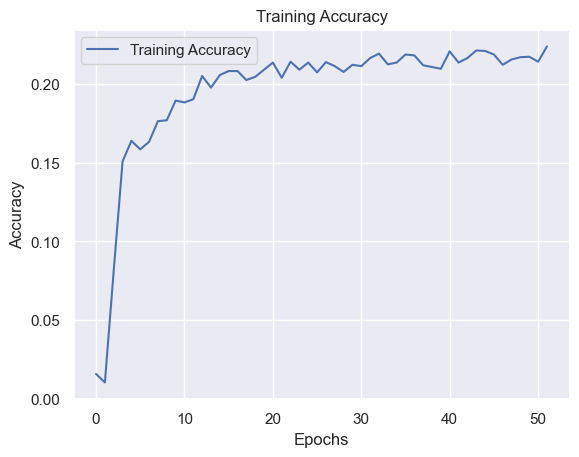

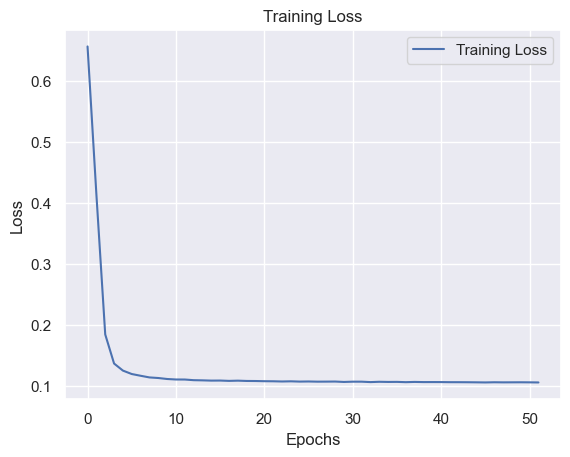

In [501]:


plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [502]:
test_loss, test_accuracy = model.evaluate(X_val.toarray(), y_val.values)
print(f'Test Accuracy= {round(test_accuracy,2)*100}%\nTest Loss= {round(test_loss,2)}')

8/8 [==============================] - 0s 7ms/step - loss: 0.0959 - accuracy: 0.2198
Test Accuracy= 22.0%
Test Loss= 0.1


In [503]:


df_test.drop(columns=['index', 'Unnamed: 0', 'assessment', 'tags'], axis=1, inplace=True)
df_test.head()



,text
0,"Последнее время думаю плохо, сроки доставки давно не [NUM] мин, а цена услуг при этом выше аналогов"
1,Цены намного выше магазинных но радуют акции
2,"Доставка за [NUM] минут, заказ даже не начали собирать спустя [NUM] минут"
3,Ужасно долгая доставка
4,Добрый вечер! Вы большие молодцы. Меня всё устраивает. За исключением некоторых ребят на доставке.


In [504]:
df_test = df_test.fillna('')
df_test = df_test.replace('', 'хорошо')
df_test.isnull().sum()

text    0
dtype: int64

In [505]:
predict = preprocess_text(df_test)
predict.shape

(9015, 3)

In [506]:
pred=model.predict(predict.toarray())
print(pred)

282/282 [==============================] - 1s 2ms/step
[[0.13654654 0.0861817  0.4038602  ... 0.00769813 0.00630458 0.00333928]
 [0.1193154  0.03647617 0.02319145 ... 0.00606062 0.00589399 0.00158736]
 [0.238668   0.15933244 0.5292711  ... 0.00531393 0.00457009 0.00179547]
 ...
 [0.08341172 0.02929778 0.0660466  ... 0.00961412 0.01127207 0.00628973]
 [0.11931542 0.03647617 0.02319145 ... 0.00606062 0.00589399 0.00158736]
 [0.14844891 0.10305871 0.45272544 ... 0.00623308 0.0049584  0.00228098]]


In [557]:
from sklearn.metrics import precision_recall_curve
th0, th1, th2, th3 = 0.15,0.1,0.006,0.07


predictions = model.predict(predict.toarray())
f=open('submission.csv', 'w')
f.write("index,target")
f.write("\n")
for i in range(len(predictions)):
    
    f.write(str(df_test_copy['index'][i]))
    f.write(',')
    for j in range(50):
        if j==0 or j==2 or j==12 or j==27:
            if predictions[i, j] > th0:
                f.write(str(j))
                f.write(' ')
        if j==1 or j==3 or j==19 or j==35 or j==28:


            if predictions[i, j] > th1:
                f.write(str(j))
                f.write(' ')
        if j==46 or j==17 or j==24 or j==9 or j==34 or j==45 or j==49 or j==25 or j==32:
            if predictions[i, j] > th2:
                f.write(str(j))
                f.write(' ')
        if j==14 or j==15 or j==16 or j==4 or j==18 or j==20 or j==21 or j==22 or j==23 or j==5 or j==6 or j==7 or j==8 or j==10 or j==11 or j==13 or j==30 or j==31 or j==33 or j==36 or j==37 or j==38 or j==39 or j==40 or j==41 or j==42 or j==43 or j==44 or j==47 or j==48:
            if predictions[i, j] > th3:
                f.write(str(j))
                f.write(' ')


    
    
    f.write("\n")

f.close()
break
for i in range(len(predictions)):
    
    for j in range(50):
        if j==0 or j==2 or j==12 or j==27:
            if predictions[i, j] > th0:
                cur.append(j)
        if j==1 or j==3 or j==19 or j==35 or j==28:


            if predictions[i, j] > th1:
                cur.append(j)
        if j==4 or j==5:
            if predictions[i, j] > th1:
                cur.append(j)
    
break
predicted_labels = (predictions >= 0.15).astype(int)
class_mapping={}
for i in range(50):
    class_mapping[i]=f'{i}'


results = df_test.copy()


def get_predicted_classes(label_vector):
    return ', '.join([class_mapping[i] for i, val in enumerate(label_vector) if val == 1])

results['t'] = [get_predicted_classes(label) for label in predicted_labels]

pd.set_option('display.max_colwidth', None)

multi_label_rows = results[results['t'].str.contains(',')]
multi_label_rows.head(5)




282/282 [==============================] - 1s 2ms/step


SyntaxError: 'break' outside loop (590376666.py, line 39)

In [508]:
results['index']=df_test_copy['index']
results.head()

,text,t,index
0,"Последнее время думаю плохо, сроки доставки давно не [NUM] мин, а цена услуг при этом выше аналогов",2,3135
1,Цены намного выше магазинных но радуют акции,,4655
2,"Доставка за [NUM] минут, заказ даже не начали собирать спустя [NUM] минут","0, 1, 2",22118
3,Ужасно долгая доставка,"0, 1",23511
4,Добрый вечер! Вы большие молодцы. Меня всё устраивает. За исключением некоторых ребят на доставке.,,45


In [509]:
f=open('submission.csv', 'w')
f.write("index,target")
f.write("\n")
for i in range(len(results)):
    
    f.write(str(results['index'][i]))
    f.write(',')
    a=results['t'][i].replace(',', '')
    f.write(a)
    
    f.write("\n")

f.close()